In [1]:
import sys

# !{sys.executable} -m pip install folktables
# !{sys.executable} -m pip install great-expectations
# !{sys.executable} -m pip install absl-py
# !{sys.executable} -m pip install tensorflow==2.8.0
# !{sys.executable} -m pip install tensorflow-text==2.8.1
# !{sys.executable} -m pip install requests==2.23.0
# !{sys.executable} -m pip install pandas-profiling==3.5.0
# !{sys.executable} -m pip install jinja2==3.0.0
# !{sys.executable} -m pip install matplotlib==3.4.0
# !{sys.executable} -m pip install pandas==1.1.0
# !{sys.executable} -m pip install scikit-learn
# !{sys.executable} -m pip install ydata-synthetic
# !{sys.executable} -m pip install dataprofiler
# !{sys.executable} -m pip install ipympl
# !{sys.executable} -m pip install numpy==1.17
# !{sys.executable} -m pip install typing_extensions

In [2]:
import json
import pprint
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import folktables
from folktables import ACSDataSource

import dataprofiler as dp
from pandas_profiling import ProfileReport
from dataprofiler import Profiler, graphs

from ydata_synthetic.synthesizers.regular import RegularSynthesizer
from ydata_synthetic.synthesizers import ModelParameters, TrainParameters

In [3]:
features=['AGEP','SCHL','MAR','DIS','ESP','CIT','MIG','MIL','ANC', 'NATIVITY','DEAR','DEYE','DREM','SEX','RAC1P','PUMA','ST','OCCP','JWTR','POWPUMA','COW','POBP','RELP','WKHP','PINCP','ESR','FER']

featEmployment = [x for x in features if x not in ['FER','ESR','PINCP','WKHP','POBP','COW','PUMA','ST','OCCP','JWTR','POWPUMA']]
featIncome = [x for x in features if x not in ['FER','ESR','PINCP','DIS','ESP','CIT','MIG', 'MIL','ANC','NATIVITY','DEAR','DEYE','DREM','PUMA','ST','JWTR','POWPUMA']]
featHealthInsurance = [x for x in features if x not in ['WKHP','RELP','POBP','COW','PUMA','OCCP','JWTR','POWPUMA']]
featTravelTime = [x for x in features if x not in ['FER','RELP','POBP','MIL','ANC','NATIVITY','DEAR','DEYE','DREM']]

In [4]:
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')

acs_data_ut = data_source.get_data(states=["UT"], download=True)
acs_data_wy = data_source.get_data(states=["WY"], download=True)

acs_data_az = data_source.get_data(states=["AZ"], download=True)
acs_data_ca = data_source.get_data(states=["CA"], download=True)

acs_data_ny = data_source.get_data(states=["NY"], download=True)

#states = ['UT', 'WY', 'AZ', 'CA', 'NY'...]

In [5]:
def get_variable_name(variable):
    globals_dict = globals()

    return [var_name for var_name in globals_dict if globals_dict[var_name] is variable]

In [6]:
def create_csv(task,acs_data):

    get_variable_name(task)[0]
    
    _feat, _label, _group = task.df_to_pandas(acs_data)
    _dataset = pd.concat([_feat, _label], axis=1)

    _dataset.to_csv(f'csvTask/{get_variable_name(task)[0]}_{get_variable_name(acs_data)[0]}.csv', index=False)

In [7]:
Employment = folktables.BasicProblem(
    features=featEmployment,
    target='ESR',
    target_transform=lambda x: x == 1,
    group='SEX',
    preprocess=folktables.acs.adult_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

In [8]:
Income = folktables.BasicProblem(
    features=featIncome,
    target='PINCP',
    target_transform=lambda x: x > 50000,
    group='SEX',
    preprocess=folktables.acs.adult_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

In [9]:
HealthInsurance = folktables.BasicProblem(
    features=featHealthInsurance,
    target='HINS2',
    target_transform=lambda x: x == 1,
    group='SEX',
    preprocess=folktables.acs.adult_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

In [10]:
TravelTime = folktables.BasicProblem(
    features=featTravelTime,
    target="JWMNP",
    target_transform=lambda x: x > 20,
    group='SEX',
    preprocess=folktables.acs.adult_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

In [11]:
acs_data_list = [acs_data_ut,acs_data_wy,acs_data_az,acs_data_ca,acs_data_ny]
task_list = [Employment,Income,HealthInsurance,TravelTime]

for task in task_list:
    for acs_data in acs_data_list:
        create_csv(task, acs_data)

Exploratory Data Analysis (EDA): to discover important patterns, anomalies, business assumptions validations and so on.

In [12]:
dataset_name = "employment_ny"
data_ = pd.read_csv('csvTask/Employment_acs_data_ny.csv')

features_cat=['FER','ESR','COW','POWPUMA','JWTR','RELP','SCHL','MAR','DIS','ESP','CIT','MIG','MIL','ANC', 'NATIVITY','DEAR','DEYE','DREM','SEX','RAC1P','PUMA','ST','OCCP','POBP']
features_num=['PINCP','AGEP','WKHP']

for col in data_.columns:
    if col in features_num:
        data_[col] = data_[col].astype('int64')
    else:
        data_[col] = data_[col].astype('str')

In [13]:
# #Generating the standard profiling report
title = f"EDA: {dataset_name}"
profile = ProfileReport(data_, title=title, infer_dtypes=False)

profile_real = Profiler(data_)

2022-12-12 12:18:28.106707: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-12-12 12:18:28.106826: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (swatigpu): /proc/driver/nvidia/version does not exist
2022-12-12 12:18:28.108166: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:DataProfiler.profilers.profile_builder: Finding the Null values in the columns...  (with 3 processes)


/home/swati/anaconda3/envs/newAdult/lib/python3.8/site-packages/dataprofiler/profilers/profile_builder.py:2543: UserWarning: The data will be profiled with a sample size of 20604. All statistics will be based on this subsample and not the whole dataset.
  warnings.warn(
  0%|          | 0/17 [00:00<?, ?it/s]/home/swati/anaconda3/envs/newAdult/lib/python3.8/site-packages/dataprofiler/profilers/profile_builder.py:610: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_series = df_series.loc[true_sample_list]
/home/swati/anaconda3/envs/newAdult/lib/python3.8/site-packages/dataprofiler/profilers/profile_builder.py:610: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_series = df_series.loc[true_sample_list]
  6%|▌         | 1/17 [00:00<00:02,  7.13it/s]/home/swati/anaconda3/envs/newAdult/lib/python3.8/site-packages/dataprofiler/profilers/profile_builder.py

INFO:DataProfiler.profilers.profile_builder: Calculating the statistics...  (with 4 processes)


100%|██████████| 17/17 [00:03<00:00,  5.25it/s]


In [14]:
# #Exploring as HTML outside Jupyter Notebook
profile.to_file(f'profileTaskHtml/{dataset_name}_profile.html')

# #Exploring as HTML inside Jupyter Notebook
# profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/home/swati/anaconda3/envs/newAdult/lib/python3.8/site-packages/pandas_profiling/model/pandas/correlations_pandas.py:29: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  return df.corr(method="spearman")
/home/swati/anaconda3/envs/newAdult/lib/python3.8/site-packages/pandas_profiling/model/pandas/correlations_pandas.py:36: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  return df.corr(method="pearson")
/home/swati/anaconda3/envs/newAdult/lib/python3.8/site-packages/pandas_profiling/model/pandas/correlations_pandas.py:43: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Sel

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [15]:
# #Exploring as json profile
profile.to_file(f'profileTaskJson/{dataset_name}_profile.json')

Render JSON:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [16]:
file_ = open(f'profileTaskJson/{dataset_name}_profile.json','r')

json_profile = json.load(file_)

num_cols = [col for col, val in json_profile['variables'].items() if val['type']=='Numeric']
cat_cols = [col for col, val in json_profile['variables'].items() if val['type']=='Categorical']

print(f'Number of categorical: {len(cat_cols)}, Number of numerical: {len(num_cols)}')

Number of categorical: 16, Number of numerical: 1


The synthetic data generation

In [17]:
#Defining the training parameters of Models

## Setting the architecture hyperparameters
noise_dim = 128
dim = 128
batch_size = 128

#Defined as per the literature on WGAN
beta_1 = 0.5
beta_2 = 0.9

# 1e-5 dragan
learning_rate = 1e-5

log_step = 100
epochs = 11

models_dir = 'cache'

In [18]:
gan_args = ModelParameters(batch_size=batch_size,
                           lr=learning_rate,
                           betas=(beta_1, beta_2),
                           noise_dim=noise_dim,
                           layers_dim=dim)

train_args = TrainParameters(epochs=epochs,
                             sample_interval=log_step)

In [19]:
#Init the synthesizer model
# dragan (n_discriminator=3)
# wgan (n_critic=10)
# wgangp n_critic=2

model_name = 'wgangp'

synth = RegularSynthesizer(modelname=model_name, model_parameters=gan_args, n_critic=2)

In [20]:
#Model training
synth.fit(data = data_, train_arguments = train_args, num_cols = num_cols, cat_cols = cat_cols)

#Saving the trained synthesizer
synth.save(f'synthTaskPkl/{dataset_name}_{model_name}_synth.pkl') 

  9%|▉         | 1/11 [00:26<04:27, 26.71s/it]

Epoch: 0 | disc_loss: -0.11598329991102219 | gen_loss: 0.06355102360248566


 18%|█▊        | 2/11 [00:51<03:52, 25.78s/it]

Epoch: 1 | disc_loss: -0.0838475376367569 | gen_loss: 0.01779848523437977


 27%|██▋       | 3/11 [01:16<03:23, 25.44s/it]

Epoch: 2 | disc_loss: -0.08551366627216339 | gen_loss: 0.011756161227822304


 36%|███▋      | 4/11 [01:42<02:57, 25.42s/it]

Epoch: 3 | disc_loss: -0.09117566794157028 | gen_loss: 0.02119067683815956


 45%|████▌     | 5/11 [02:07<02:32, 25.44s/it]

Epoch: 4 | disc_loss: -0.09784441441297531 | gen_loss: 0.019511889666318893


 55%|█████▍    | 6/11 [02:32<02:06, 25.31s/it]

Epoch: 5 | disc_loss: -0.10329236835241318 | gen_loss: 0.014080505818128586


 64%|██████▎   | 7/11 [02:57<01:40, 25.20s/it]

Epoch: 6 | disc_loss: -0.1069607064127922 | gen_loss: 0.013367688283324242


 73%|███████▎  | 8/11 [03:22<01:15, 25.15s/it]

Epoch: 7 | disc_loss: -0.1078178882598877 | gen_loss: 0.011792030185461044


 82%|████████▏ | 9/11 [03:47<00:50, 25.10s/it]

Epoch: 8 | disc_loss: -0.11193545907735825 | gen_loss: 0.012757506221532822


 91%|█████████ | 10/11 [04:12<00:25, 25.00s/it]

Epoch: 9 | disc_loss: -0.1123923510313034 | gen_loss: 0.009389570914208889


100%|██████████| 11/11 [04:37<00:00, 25.27s/it]

Epoch: 10 | disc_loss: -0.11335256695747375 | gen_loss: 0.014304395765066147


In [21]:
synth = RegularSynthesizer.load(f'synthTaskPkl/{dataset_name}_{model_name}_synth.pkl')

synth_sample = synth.sample(n_samples=len(data_))

#Saving the synthetic sample as CSV
synth_sample.to_csv(f'synthTaskCsv/{dataset_name}_{model_name}_synth.csv',index=False)

Synthetic data generation: 100%|██████████| 805/805 [00:02<00:00, 331.19it/s]


In [22]:
# #Generating the standard profiling report
title = f"Synthetic profile: {dataset_name}"
profile_synth_dt = ProfileReport(synth_sample, title=title, infer_dtypes=False)

profile_synth = Profiler(synth_sample)

INFO:DataProfiler.profilers.profile_builder: Finding the Null values in the columns...  (with 3 processes)


/home/swati/anaconda3/envs/newAdult/lib/python3.8/site-packages/dataprofiler/profilers/profile_builder.py:2543: UserWarning: The data will be profiled with a sample size of 20608. All statistics will be based on this subsample and not the whole dataset.
  warnings.warn(
  0%|          | 0/17 [00:00<?, ?it/s]/home/swati/anaconda3/envs/newAdult/lib/python3.8/site-packages/dataprofiler/profilers/profile_builder.py:610: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_series = df_series.loc[true_sample_list]
/home/swati/anaconda3/envs/newAdult/lib/python3.8/site-packages/dataprofiler/profilers/profile_builder.py:610: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_series = df_series.loc[true_sample_list]
/home/swati/anaconda3/envs/newAdult/lib/python3.8/site-packages/dataprofiler/profilers/profile_builder.py:610: FutureWarning: Passing a set as an index

INFO:DataProfiler.profilers.profile_builder: Calculating the statistics...  (with 4 processes)


100%|██████████| 17/17 [00:02<00:00,  5.92it/s]
/home/swati/anaconda3/envs/newAdult/lib/python3.8/site-packages/dataprofiler/profilers/utils.py:733: RuntimeWarning: Insufficient number of categories. Chi-squared test cannot be performed.
  warnings.warn(


In [23]:
# #Exploring as HTML outside Jupyter Notebook
profile_synth_dt.to_file(f'profileTaskHtml/{dataset_name}_profile_synthetic.html')

# #Exploring as HTML inside Jupyter Notebook
# profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/home/swati/anaconda3/envs/newAdult/lib/python3.8/site-packages/pandas_profiling/model/pandas/correlations_pandas.py:29: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  return df.corr(method="spearman")
/home/swati/anaconda3/envs/newAdult/lib/python3.8/site-packages/pandas_profiling/model/pandas/correlations_pandas.py:36: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  return df.corr(method="pearson")
/home/swati/anaconda3/envs/newAdult/lib/python3.8/site-packages/pandas_profiling/model/pandas/correlations_pandas.py:43: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Sel

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
# #Exploring as json profile
profile_synth_dt.to_file(f'profileTaskJson/{dataset_name}_profile_synthetic.json')

Render JSON:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [25]:
file_synth = open(f'profileTaskJson/{dataset_name}_profile_synthetic.json','r')

json_profile_synth = json.load(file_synth)

num_cols_synth = [col for col, val in json_profile_synth['variables'].items() if val['type']=='Numeric']
cat_cols_synth = [col for col, val in json_profile_synth['variables'].items() if val['type']=='Categorical']

print(f'Number of categorical: {len(cat_cols_synth)}, Number of numerical: {len(num_cols_synth)}')

Number of categorical: 16, Number of numerical: 1


Synthetic data & expectations

In [26]:
def summarize_data_stats(data_stats, show_feats = None):
    "This function will help us preserving only the most indicative elements of the report in our analysis."
    summarized = {}
    stats_exclude_keys = ['min','max','sum','mean','median','mode','avg_predictions', 'data_label_representation', 'data_type_representation', 'histogram', 'times', 'precision', 'label_representation', 'categorical_count', 'categories', 't-test']
    for feat_info in data_stats:
        name = feat_info['column_name']
        if show_feats and name not in show_feats:
            continue
        stats = {k: v for k, v in feat_info.pop('statistics').items() if k not in stats_exclude_keys}
        feat_info['statistics'] = stats
        summarized[name] = feat_info
    return summarized

In [27]:
synth_diff_report = profile_real.diff(profile_synth)

show_feats = ['MAR','DIS']

# Print the report
# print(json.dumps((summarize_data_stats(synth_diff_report['data_stats'],show_feats)),indent=4))

/home/swati/anaconda3/envs/newAdult/lib/python3.8/site-packages/dataprofiler/profilers/numerical_column_stats.py:665: RuntimeWarning: divide by zero encountered in log
  iter_psi = (other_percent - self_percent) * np.log(


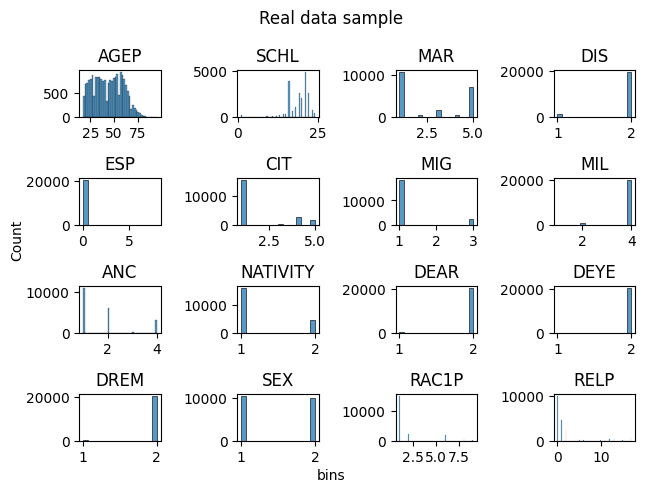

In [28]:
plt.real_fig = graphs.plot_histograms(profile_real)
plt.real_fig.suptitle('Real data sample')
plt.real_fig.tight_layout()

plt.show()

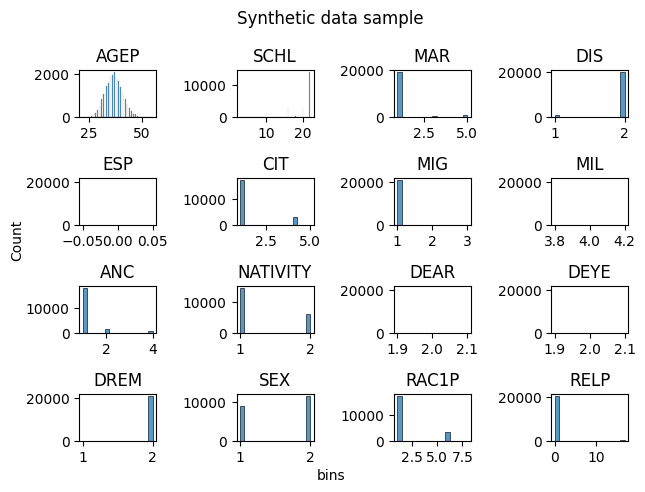

In [29]:
plt.synth_fig1 = graphs.plot_histograms(profile_synth)
plt.synth_fig1.suptitle('Synthetic data sample')
plt.synth_fig1.tight_layout()

plt.show()

ML Utility Evaluation

In [30]:
import numpy as np
import pandas as pd 
from sklearn import metrics
from sklearn import model_selection
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm,tree
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import wasserstein_distance
from scipy.spatial import distance
import warnings

from sklearn.model_selection import train_test_split

In [31]:
def supervised_model_training(x_train, y_train, x_test, y_test, model_name):
  
  """
  Trains and evaluates commonly used ML models

  Inputs:
  1) x_train -> indepedent features of training dataset
  2) y_train -> dependent feature of training dataset
  3) x_test -> independent features of testing dataset
  4) y_test -> dependent feature of testing dataset 
  5) model_name -> name of ML model to be used


  Outputs:
  1) List of metrics containing accuracy, auc and f1-score of trained ML model as achieved on test-set.
  
  """
  
  # Selecting the model
  if model_name == 'lr':
    model  = LogisticRegression(random_state=42,max_iter=500) 
  elif model_name == 'svm':
    model  = svm.SVC(random_state=42,probability=True)
  elif model_name == 'dt':
    model  = tree.DecisionTreeClassifier(random_state=42)
  elif model_name == 'rf':      
    model = RandomForestClassifier(random_state=42)
  elif model_name == "mlp":
    model = MLPClassifier(random_state=42,max_iter=100)
  
  # Fitting the model and computing predictions on test data
  model.fit(x_train, y_train)
  pred = model.predict(x_test)

  # In case of multi-class classification AUC and F1-scores are computed using weighted averages across all distinct labels
  if len(np.unique(y_train))>2:
    predict = model.predict_proba(x_test)        
    acc = metrics.accuracy_score(y_test,pred)*100
    auc = metrics.roc_auc_score(y_test, predict,average="weighted",multi_class="ovr")
    f1_score = metrics.precision_recall_fscore_support(y_test, pred,average="weighted")[2]
    return [acc, auc, f1_score] 

  else:
    predict = model.predict_proba(x_test)[:,1]    
    acc = metrics.accuracy_score(y_test,pred)*100
    auc = metrics.roc_auc_score(y_test, predict)
    f1_score = metrics.precision_recall_fscore_support(y_test,pred)[2].mean()
    return [acc, auc, f1_score] 

In [32]:
# Split Synth data

synth_sample = pd.read_csv(f'synthTaskCsv/{dataset_name}_wgangp_synth.csv')
synth_sample_tmp = pd.read_csv(f'synthTaskCsv/{dataset_name}_wgangp_synth.csv')

X_s = scaler.fit_transform(synth_sample_tmp.drop('ESR', 1))
Y_s = synth_sample_tmp['ESR'].values

X_train, X_test, Y_train, Y_test = train_test_split(X_s, Y_s, test_size=0.2)

NameError: name 'scaler' is not defined

In [ ]:
print(f'Model evaluation\n')

acc, auc, f1_score = supervised_model_training(x_train, y_train, x_test, y_test, 'lr')
acc_s, auc_s, f1_score_s = supervised_model_training(X_train, Y_train, X_test, Y_test, 'lr')

print('LogisticRegression:')
print(f'Real: Acc: {acc}, AUC: {auc}, f1_score: {f1_score}')
print(f'Synth: Acc: {acc_s}, AUC: {auc_s}, f1_score: {f1_score_s}\n')

acc, auc, f1_score = supervised_model_training(x_train, y_train, x_test, y_test, 'dt')
acc_s, auc_s, f1_score_s = supervised_model_training(X_train, Y_train, X_test, Y_test, 'dt')

print('DecisionTree:')
print(f'Real: Acc: {acc}, AUC: {auc}, f1_score: {f1_score}')
print(f'Synth: Acc: {acc_s}, AUC: {auc_s}, f1_score: {f1_score_s}\n')

Model evaluation

LogisticRegression:
Real: Acc: 88.51249696675563, AUC: 0.6500616707588386, f1_score: 0.49394302467853984
Synth: Acc: 95.41440217391305, AUC: 0.6951877223364414, f1_score: 0.4893223746125679

DecisionTree:
Real: Acc: 83.32443581654938, AUC: 0.6166815829212343, f1_score: 0.5893899170892041
Synth: Acc: 95.2251552795031, AUC: 0.7189405399395847, f1_score: 0.505407034940556



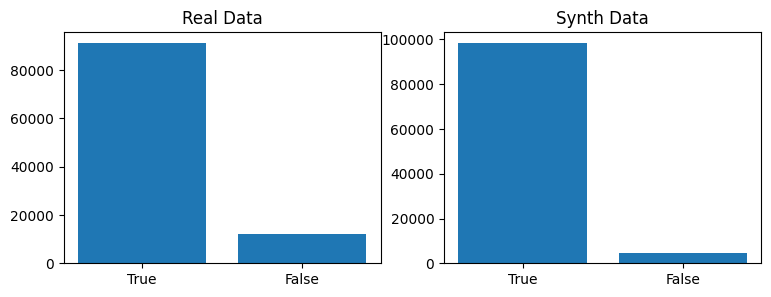

In [ ]:
# Generate bar charts to show class distribution in real and synthetic data

real_true = data_['ESR'].value_counts()['True']
real_false = data_['ESR'].value_counts()['False']

synth_true = synth_sample['ESR'].value_counts()[True]
synth_false = synth_sample['ESR'].value_counts()[False]

height_real = [real_true, real_false]
height_synth = [synth_true, synth_false]

bars = ('True', 'False')
y_pos = np.arange(len(bars))

# Create bars
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,3))

ax1.bar(y_pos, height_real)
ax1.set_title('Real Data')
ax1.set_xticks(y_pos, bars)

ax2.bar(y_pos, height_synth)
ax2.set_title('Synth Data')
ax2.set_xticks(y_pos, bars)

# Show graphic
plt.show()

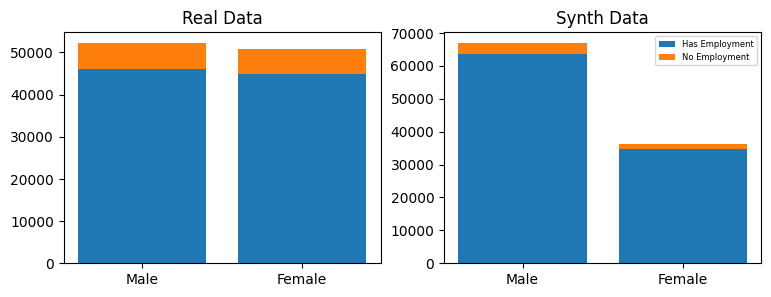

In [ ]:
# Real Data

x = ['Male', 'Female']
y1 = [data_[data_['ESR'].eq('True')].value_counts(subset=['SEX'])[0],data_[data_['ESR'].eq('True')].value_counts(subset=['SEX'])[1]]
y2 = [data_[data_['ESR'].eq('False')].value_counts(subset=['SEX'])[0],data_[data_['ESR'].eq('False')].value_counts(subset=['SEX'])[1]]

# Synth Data

y1_s = [synth_sample[synth_sample['ESR'].eq(True)].value_counts(subset=['SEX'])[1.0],synth_sample[synth_sample['ESR'].eq(True)].value_counts(subset=['SEX'])[2.0]]
y2_s = [synth_sample[synth_sample['ESR'].eq(False)].value_counts(subset=['SEX'])[1.0],synth_sample[synth_sample['ESR'].eq(False)].value_counts(subset=['SEX'])[2.0]]
 
# Create bars
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,3))

ax1.bar(x, y1)
ax1.bar(x, y2, bottom=y1)
ax1.set_title('Real Data')

ax2.bar(x, y1_s)
ax2.bar(x, y2_s, bottom=y1_s)
ax2.set_title('Synth Data')

plt.legend(['Has Employment','No Employment'],loc=1, prop={'size': 6})

# Show graphic
plt.show()